# Abdallah Nassur | Lucas Taranne | Amine Belhaimeur | Amine Cherif

In [ ]:
!pip install numpy pandas gym tensorflow scikit-learn matplotlib

In [1]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pickle
import joblib

In [3]:
# import df from csv
# https://firstratedata.com/free-intraday-data
df = pd.read_csv('AAPL/AAPL_1min_firstratedata.csv')
df.head()

,timestamp,open,high,low,close,volume
0,2022-09-30 04:00:00,143.59,143.59,143.10,143.49,4060
1,2022-09-30 04:01:00,143.49,143.49,143.38,143.38,481
2,2022-09-30 04:02:00,143.22,143.22,143.22,143.22,107
3,2022-09-30 04:03:00,143.39,143.39,143.21,143.23,2811
4,2022-09-30 04:04:00,143.30,143.32,143.30,143.32,309


In [4]:
# display shape
df.shape

(193829, 6)

In [6]:
# features and target
features = ['open', 'high', 'low', 'volume']
target = ['close']

X = df[features].values
y = df[target].values

In [7]:
# Normalisation
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# save scaler
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

In [8]:
# creating train and test datasets
look_back = 20 # number of previous minutes to consider

train_size = int(len(X_scaled) * 0.8)
X_train, y_train = X_scaled[:train_size], y_scaled[:train_size]
X_test, y_test = X_scaled[train_size:], y_scaled[train_size:]

train_generator = TimeseriesGenerator(
    X_train, y_train,
    length=look_back,
    batch_size=32
)

test_generator = TimeseriesGenerator(
    X_test, y_test,
    length=look_back,
    batch_size=1
)

In [9]:
# model definition
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, len(features))),

    LSTM(30),

    Dense(1)
])

# This model is a CNN + LSTM model
# We're not using it for now because it's not as good as the LSTM model
"""model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back, len(features))),
    MaxPooling1D(pool_size=2),

    LSTM(50, return_sequences=True),
    
    LSTM(30),

    Dense(1)
])"""

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model_bourse.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# validation set
val_size = max(look_back, int(0.1 * len(X_train)))
val_generator = TimeseriesGenerator(
    X_train[-val_size:], y_train[-val_size:], length=look_back, batch_size=32
)

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# training
history = lstm_model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/20


c:\Users\abdal\anaconda3\envs\titanic_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\abdal\anaconda3\envs\titanic_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4842/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - loss: 0.0019 - val_loss: 1.6334e-04 - learning_rate: 0.0010
Epoch 2/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 56s 12ms/step - loss: 5.5297e-05 - val_loss: 2.0872e-04 - learning_rate: 0.0010
Epoch 3/20
4844/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8322e-05

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - loss: 4.8330e-05 - val_loss: 8.7171e-06 - learning_rate: 0.0010
Epoch 4/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0767e-05

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 66s 14ms/step - loss: 6.0766e-05 - val_loss: 3.6431e-06 - learning_rate: 0.0010
Epoch 5/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 69s 14ms/step - loss: 5.0170e-05 - val_loss: 5.3220e-06 - learning_rate: 0.0010
Epoch 6/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step - loss: 4.4578e-06 - val_loss: 2.0605e-05 - learning_rate: 2.0000e-04
Epoch 7/20
4844/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9525e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 67s 14ms/step - loss: 5.9522e-06 - val_loss: 2.2774e-06 - learning_rate: 2.0000e-04
Epoch 8/20
4843/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5933e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 67s 14ms/step - loss: 3.5933e-06 - val_loss: 2.2324e-06 - learning_rate: 4.0000e-05
Epoch 9/20
4843/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5499e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - loss: 3.5499e-06 - val_loss: 2.1731e-06 - learning_rate: 4.0000e-05
Epoch 10/20
4844/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1362e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 67s 14ms/step - loss: 3.1363e-06 - val_loss: 2.0506e-06 - learning_rate: 8.0000e-06
Epoch 11/20
4845/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.4643e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 70s 14ms/step - loss: 3.4643e-06 - val_loss: 1.9822e-06 - learning_rate: 8.0000e-06
Epoch 12/20
4844/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1319e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 64s 13ms/step - loss: 3.1320e-06 - val_loss: 1.9742e-06 - learning_rate: 1.6000e-06
Epoch 13/20
4844/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4411e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 68s 14ms/step - loss: 3.4411e-06 - val_loss: 1.9736e-06 - learning_rate: 1.6000e-06
Epoch 14/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 79s 16ms/step - loss: 3.5537e-06 - val_loss: 1.9891e-06 - learning_rate: 3.2000e-07
Epoch 15/20
4842/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3305e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step - loss: 3.3305e-06 - val_loss: 1.9714e-06 - learning_rate: 3.2000e-07
Epoch 16/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2355e-06

4846/4846 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - loss: 3.2355e-06 - val_loss: 1.9698e-06 - learning_rate: 6.4000e-08
Epoch 17/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 67s 14ms/step - loss: 3.2572e-06 - val_loss: 1.9728e-06 - learning_rate: 6.4000e-08
Epoch 18/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - loss: 3.1602e-06 - val_loss: 1.9711e-06 - learning_rate: 1.2800e-08
Epoch 19/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 46s 10ms/step - loss: 3.3485e-06 - val_loss: 1.9703e-06 - learning_rate: 1.2800e-08
Epoch 20/20
4846/4846 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 3.2885e-06 - val_loss: 1.9703e-06 - learning_rate: 2.5600e-09


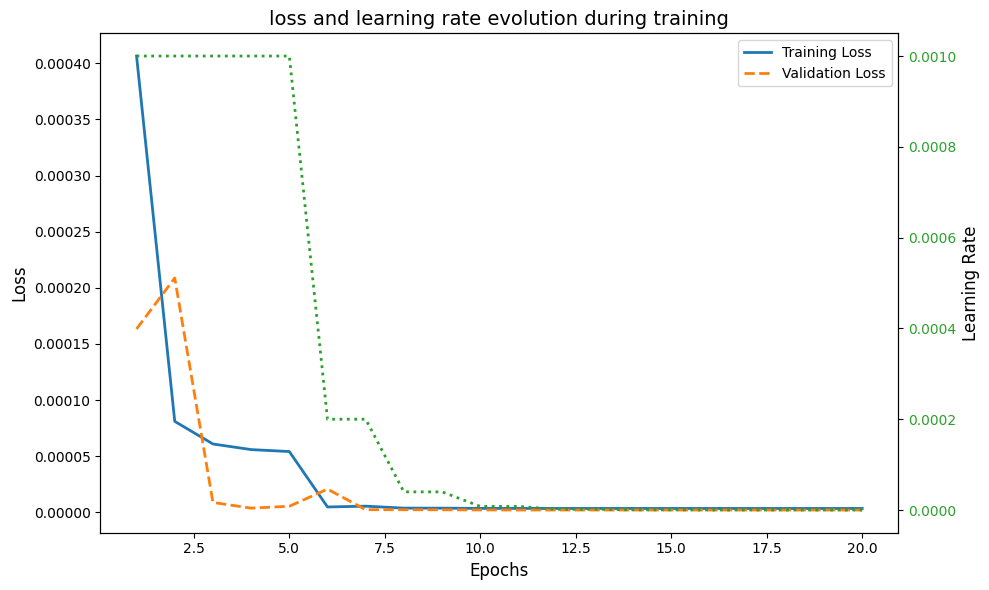

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
lr = history.history['learning_rate']
epochs = range(1, len(loss) + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(epochs, loss, label='Training Loss', color='tab:blue', linewidth=2)
ax1.plot(epochs, val_loss, label='Validation Loss', color='tab:orange', linewidth=2, linestyle='--')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(epochs, lr, label='Learning Rate', color='tab:green', linewidth=2, linestyle=':')
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title('loss and learning rate evolution during training', fontsize=14)
fig.tight_layout()
plt.show()


In [11]:
# prediction
predictions_scaled = lstm_model.predict(test_generator)
predictions = scaler_y.inverse_transform(predictions_scaled)

38746/38746 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step


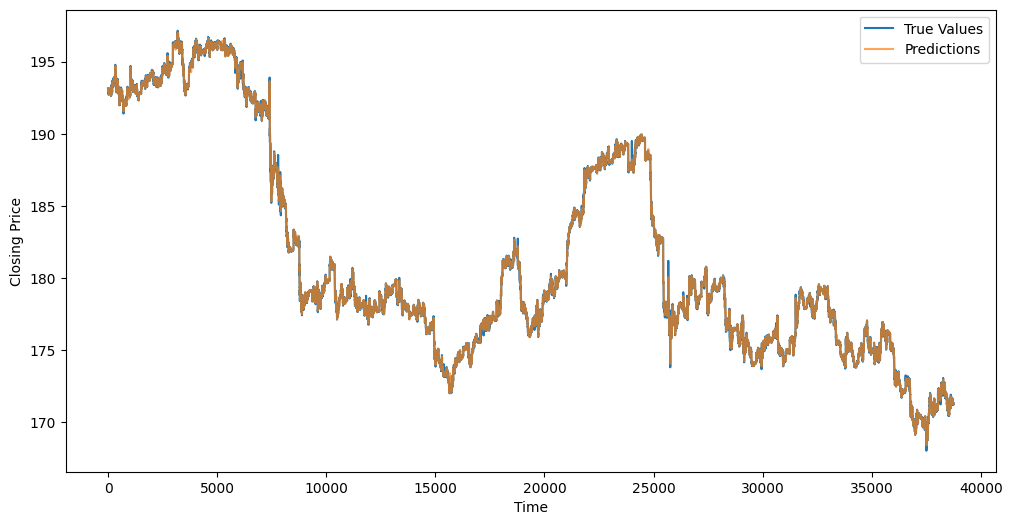

In [12]:
# comparison with true series
true_values = y[train_size + look_back:]

plt.figure(figsize=(12,6))
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

In [13]:
# save model
lstm_model.save("lstm_model.h5")

# Observations

Le modèle suit de très près la tendance des prix.

## Défis 
- Surentraînement -> Early Stopping
- Convergence -> Réduction du learning rate

## Améliorations
- Mécanisme d'attention (CBAM)
- Précéder le LSTM par un CNN chargé de détecter les tendances


# DQN

In [24]:
import numpy as np
import pandas as pd
from gym import Env
from gym.spaces import Discrete, Box

import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import tensorflow as tf

class TradingEnv(Env):
    def __init__(self, data: pd.DataFrame, scaler_y: sklearn.preprocessing._data.MinMaxScaler, initial_balance=1_000_000):
        """
        Initialize the trading environment.

        Args:
        - data (pd.DataFrame): Normalized stock data with columns ['Open', 'High', 'Low', 'Close', 'Volume'].
        - scaler_y (MinMaxScaler): Fitted scaler used to normalize the 'Close' price.
        - initial_balance (float): Starting balance for the agent.
        """
        super(TradingEnv, self).__init__()

        # Dataset and trading parameters
        self.data = data.reset_index(drop=True)
        self.scaler_y = scaler_y  # store scaler to invert Close values
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.net_worth = initial_balance
        self.max_net_worth = initial_balance
        self.done = False

        # Action space: 0 = BUY, 1 = HOLD, 2 = SELL
        self.action_space = Discrete(3)

        # Observation space: [balance, shares held, net worth, price data...]
        self.observation_space = Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(self.data.columns) + 3,),
            dtype=np.float32,
        )

    def _get_real_close(self, scaled_close):
        """Inverse transform a normalized close price back to its real value."""
        return self.scaler_y.inverse_transform(np.array(scaled_close).reshape(-1, 1))[0, 0]

    def _get_observation(self):
        """Create the observation vector (still normalized)."""
        obs = np.array([
            self.balance,
            self.shares_held,
            self.net_worth,
            *self.data.iloc[self.current_step].values
        ], dtype=np.float32)
        return obs

    def _take_action(self, action):
        """Execute trading logic (buy, sell, hold)."""
        # Get the real (non-normalized) current close price
        scaled_close = self.data.iloc[self.current_step]['close']
        current_price = self._get_real_close(scaled_close)

        if action == 0:  # BUY
            shares_to_buy = int(self.balance // current_price)
            if shares_to_buy > 0:
                self.shares_held += shares_to_buy
                self.balance -= shares_to_buy * current_price

        elif action == 2:  # SELL
            if self.shares_held > 0:
                self.balance += self.shares_held * current_price
                self.shares_held = 0

        # 💰 Update net worth and track the max
        self.net_worth = self.balance + self.shares_held * current_price
        self.max_net_worth = max(getattr(self, 'max_net_worth', 0), self.net_worth)

    def step(self, action):
        """Execute one step in the environment."""
        prev_net_worth = self.net_worth

        # Take the chosen action
        self._take_action(action)

        # Move to next time step
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        # Reward is relative change in net worth
        reward = (self.net_worth - prev_net_worth) / prev_net_worth

        # Return observation, reward, done flag, and info
        obs = self._get_observation()
        return obs, reward, self.done, {}

    def reset(self):
        """Reset environment to the initial state."""
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.current_step = 0
        self.done = False
        return self._get_observation()

    def render(self, mode="human"):
        """Display current state with *real* (unscaled) prices."""
        scaled_close = self.data.iloc[self.current_step]['close']
        real_close = self._get_real_close(scaled_close)

        print(f"Step: {self.current_step}")
        print(f"Balance: ${self.balance:,.2f}")
        print(f"Shares Held: {self.shares_held}")
        print(f"Net Worth: ${self.net_worth:,.2f}")
        print(f"Max Net Worth: ${self.max_net_worth:,.2f}")
        print(f"Current (Real) Price: ${real_close:,.2f}\n")

In [25]:
class DQNAgentLSTM:
    def __init__(self, state_size, action_size, window_size=10):
        self.state_size = state_size
        self.action_size = action_size
        self.window_size = window_size

        # hyperparameters
        self.gamma = 0.95 # to prefer future rewards
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01 # minimum exploration rate
        self.epsilon_decay = 0.995 # exploration rate decay
        self.learning_rate = 0.001 # learning rate
        self.memory = deque(maxlen=2000)

        # load LSTM model
        self.lstm_model = load_model("lstm_model.h5")

        # build DQN model
        self.model = self._build_dqn_model()
        self.target_model = self._build_dqn_model()
        self.update_target_model()

    def _build_dqn_model(self):
        """
        Build the DQN model
        """
        model = Sequential()
        model.add(Dense(64, activation='relu', input_dim=self.state_size + 1))  # last state + predicted_close
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
        return model

    def update_target_model(self):
        """
        Update the target model
        """
        self.target_model.set_weights(self.model.get_weights())

    def save_model(self, filename):
        """
        Save the model
        """
        self.model.save(filename)

    def remember(self, augmented_state, action, reward, next_augmented_state, done):
        """
        Remember the experience
        """
        self.memory.append((augmented_state, action, reward, next_augmented_state, done))

    def act(self, augmented_state):
        """
        Act based on the state
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # do a random action

        q_values = self.model.predict(augmented_state, verbose=0) # act by maximizing Q-value
        return np.argmax(q_values[0])
            
    def replay(self, batch_size=32):
        """
        Vectorized experience replay for faster training
        """

        # skip training if not enough samples in memory
        if len(self.memory) < batch_size:
            return

        # batch selection
        minibatch = random.sample(self.memory, batch_size)

        # vectorized decomposition
        states = np.array([s[0] for s, _, _, _, _ in minibatch])
        next_states = np.array([ns[0] for _, _, _, ns, _ in minibatch])
        actions = np.array([a for _, a, _, _, _ in minibatch])
        rewards = np.array([r for _, _, r, _, _ in minibatch])
        dones = np.array([d for _, _, _, _, d in minibatch])

        # predict current Q-values and next Q-values (from target model)
        q_values = self.model.predict(states, verbose=0)
        q_next = self.target_model.predict(next_states, verbose=0)

        # vectorized target Q-value calculation
        targets = q_values.copy()
        max_next_q = np.amax(q_next, axis=1)
        targets[np.arange(batch_size), actions] = rewards + (1 - dones) * self.gamma * max_next_q

        # batch training on the target Q-values
        self.model.fit(states, targets, batch_size=batch_size, verbose=0)

        # epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [26]:
df = pd.read_csv('AMZN/AMZN_1min_firstratedata.csv')
df.head()


,timestamp,open,high,low,close,volume
0,2022-09-30 04:00:00,115.88,115.88,115.88,115.88,100
1,2022-09-30 04:01:00,116.05,116.05,116.05,116.05,454
2,2022-09-30 04:02:00,116.09,116.09,116.09,116.09,200
3,2022-09-30 04:03:00,115.94,115.94,115.94,115.94,804
4,2022-09-30 04:04:00,115.97,115.97,115.97,115.97,100


In [27]:
# Load saved scalers
scaler_X = joblib.load('scaler_X.pkl')  # trained on ['Open', 'High', 'Low', 'Volume']
scaler_y = joblib.load('scaler_y.pkl')  # trained on ['Close']

# Normalize Close column using scaler_y
df[['close']] = scaler_y.transform(df[['close']])

# Normalize all X features at once using scaler_X
df[['open', 'high', 'low', 'volume']] = scaler_X.transform(
    df[['open', 'high', 'low', 'volume']]
)

# remove 'timestamp'
df = df.drop(columns=['timestamp'])

df


c:\Users\abdal\anaconda3\envs\titanic_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
c:\Users\abdal\anaconda3\envs\titanic_env\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


,open,high,low,close,volume
0,-0.113088,-0.113139,-0.113468,-0.113090,0.000000
1,-0.110777,-0.110841,-0.111142,-0.110779,0.000007
2,-0.110234,-0.110300,-0.110594,-0.110235,0.000002
3,-0.112273,-0.112328,-0.112647,-0.112274,0.000014
4,-0.111865,-0.111922,-0.112237,-0.111866,0.000000
...,...,...,...,...,...
193614,0.037243,0.036632,0.037914,0.037515,0.000006
193615,0.038059,0.037172,0.038735,0.038059,0.000000
193616,0.037787,0.036902,0.038462,0.037787,0.000000
193617,0.037787,0.037172,0.038462,0.038059,0.000015


In [29]:
from collections import deque

env = TradingEnv(data=df, scaler_y=scaler_y, initial_balance=10_000)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
window_size = 10 # the number of previous steps for LSTM

agent = DQNAgentLSTM(state_size, action_size, window_size)

# uncomment to load a saved model
# agent.model.load_weights("dqn_model_7.h5")
# agent.update_target_model()

episodes = 10
batch_size = 32

for e in range(episodes):
    state = env.reset()
    state_history = deque(maxlen=window_size)
    state_history.append(state)
    done = False
    total_reward = 0

    while not done:
        # build a sequence of past observations for the LSTM
        if len(state_history) < window_size:
            # pad with the first state if we don't yet have enough history
            padded = [state_history[0]] * (window_size - len(state_history)) + list(state_history)
        else:
            padded = list(state_history)
        state_seq = np.array(padded).reshape(1, window_size, state_size)

        # use lstm to predict the next close price based on the features ['Open', 'High', 'Low', 'Volume']
        lstm_input = state_seq[:, :, [0, 1, 2, 4]]
        predicted_close = agent.lstm_model.predict(lstm_input, verbose=0).flatten()  # shape (1,)

        # build the augmented state (last_state + predicted_close)
        # take the most recent state
        last_state = state_seq[:, -1, :]  # shape (1, state_size)
        augmented_state = np.concatenate([last_state, predicted_close.reshape(1, -1)], axis=1)  # shape (1, state_size+1)

        # dqn choose action
        action = agent.act(augmented_state)

        # perform action in environment and get the result
        next_state, reward, done, _ = env.step(action)
        state_history.append(next_state)
        
        # render the environment every 10 steps
        if env.current_step % 10 == 0:
            env.render()

        # prepare the next sequence for the next LSTM prediction
        if len(state_history) < window_size:
            next_padded = [state_history[0]] * (window_size - len(state_history)) + list(state_history)
        else:
            next_padded = list(state_history)
        next_state_seq = np.array(next_padded).reshape(1, window_size, state_size)

        # predict the next close price to build the next augmented state
        next_lstm_input = next_state_seq[:, :, [0, 1, 2, 4]]
        next_predicted_close = agent.lstm_model.predict(next_lstm_input, verbose=0).flatten()
        next_last_state = next_state_seq[:, -1, :]
        next_augmented_state = np.concatenate([next_last_state, next_predicted_close.reshape(1, -1)], axis=1)

        # store experience and train
        agent.remember(augmented_state, action, reward, next_augmented_state, done)
        agent.replay(batch_size)

        total_reward += reward

        # update target model and save
        if done:
            agent.update_target_model()
            agent.save_model(f"dqn_model_{e}.h5")
            print(f"Épisode {e+1}/{episodes} — Net Worth: {env.net_worth:.2f}, "
                  f"Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}\n")

c:\Users\abdal\anaconda3\envs\titanic_env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step: 10
Balance: $10,001.72
Shares Held: 0
Net Worth: $10,001.72
Max Net Worth: $10,018.06
Current (Real) Price: $115.96

Step: 20
Balance: $43.78
Shares Held: 86
Net Worth: $10,018.06
Max Net Worth: $10,018.06
Current (Real) Price: $116.08

Step: 30
Balance: $51.52
Shares Held: 86
Net Worth: $9,959.58
Max Net Worth: $10,026.66
Current (Real) Price: $115.39

Step: 40
Balance: $41.20
Shares Held: 86
Net Worth: $9,982.80
Max Net Worth: $10,026.66
Current (Real) Price: $115.75

Step: 50
Balance: $81.62
Shares Held: 86
Net Worth: $9,971.62
Max Net Worth: $10,026.66
Current (Real) Price: $115.00

Step: 60
Balance: $9,970.76
Shares Held: 0
Net Worth: $9,970.76
Max Net Worth: $10,026.66
Current (Real) Price: $114.75

Step: 70
Balance: $100.54
Shares Held: 86
Net Worth: $9,977.64
Max Net Worth: $10,026.66
Current (Real) Price: $114.95



KeyboardInterrupt: 